/home/lcj/miniconda3/envs/yolo_f/lib/python3.11/site-packages/obp-0.5.5-py3.11.egg/obp/ope/meta.py:640: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95.0)` for the same effect.

  sns.barplot(


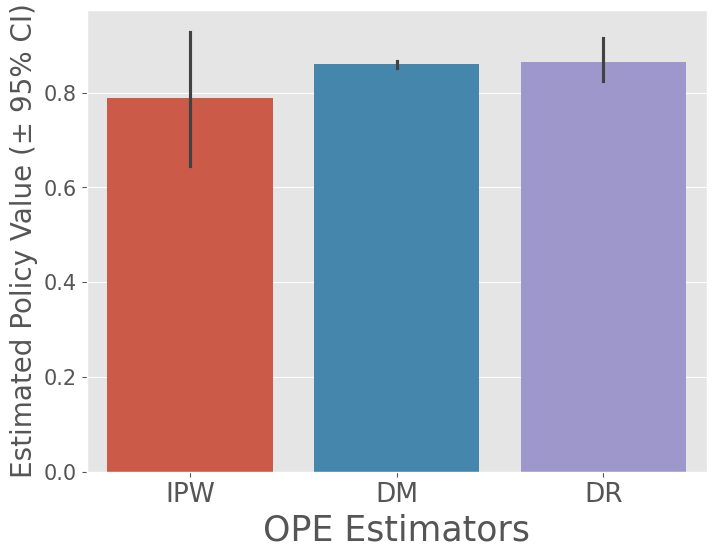

In [1]:
# implementing OPE of the IPWLearner using synthetic bandit data
from sklearn.linear_model import LogisticRegression
# import open bandit pipeline (obp)
from obp.dataset import SyntheticBanditDataset
from obp.policy import IPWLearner
from obp.ope import (
    OffPolicyEvaluation,
    RegressionModel,
    InverseProbabilityWeighting as IPW,
    DirectMethod as DM,
    DoublyRobust as DR,
)

# (1) Generate Synthetic Bandit Data
dataset = SyntheticBanditDataset(n_actions=10, reward_type="binary")
bandit_feedback_train = dataset.obtain_batch_bandit_feedback(n_rounds=1000)
bandit_feedback_test = dataset.obtain_batch_bandit_feedback(n_rounds=1000)

# (2) Off-Policy Learning
eval_policy = IPWLearner(n_actions=dataset.n_actions, base_classifier=LogisticRegression())
eval_policy.fit(
    context=bandit_feedback_train["context"],
    action=bandit_feedback_train["action"],
    reward=bandit_feedback_train["reward"],
    pscore=bandit_feedback_train["pscore"]
)
action_dist = eval_policy.predict(context=bandit_feedback_test["context"])

# (3) Off-Policy Evaluation
regression_model = RegressionModel(
    n_actions=dataset.n_actions,
    base_model=LogisticRegression(),
)
estimated_rewards_by_reg_model = regression_model.fit_predict(
    context=bandit_feedback_test["context"],
    action=bandit_feedback_test["action"],
    reward=bandit_feedback_test["reward"],
)
ope = OffPolicyEvaluation(
    bandit_feedback=bandit_feedback_test,
    ope_estimators=[IPW(), DM(), DR()]
)
ope.visualize_off_policy_estimates(
    action_dist=action_dist,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
)

In [2]:
# implementing an experiment to evaluate the accuracy of OPE using classification data
from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
# import open bandit pipeline (obp)
from obp.dataset import MultiClassToBanditReduction
from obp.ope import OffPolicyEvaluation, InverseProbabilityWeighting as IPW

# (1) Data Loading and Bandit Reduction
X, y = load_digits(return_X_y=True)
dataset = MultiClassToBanditReduction(X=X, y=y, base_classifier_b=LogisticRegression(random_state=12345))
dataset.split_train_eval(eval_size=0.7, random_state=12345)
bandit_feedback = dataset.obtain_batch_bandit_feedback(random_state=12345)

# (2) Evaluation Policy Derivation
# obtain action choice probabilities of an evaluation policy
action_dist = dataset.obtain_action_dist_by_eval_policy(base_classifier_e=RandomForestClassifier(random_state=12345))
# calculate the ground-truth performance of the evaluation policy
ground_truth = dataset.calc_ground_truth_policy_value(action_dist=action_dist)
print(ground_truth)
0.9634340222575517

# (3) Off-Policy Evaluation and Evaluation of OPE
ope = OffPolicyEvaluation(bandit_feedback=bandit_feedback, ope_estimators=[IPW()])
# evaluate the estimation performance (accuracy) of IPW by the relative estimation error (relative-ee)
relative_estimation_errors = ope.evaluate_performance_of_estimators(
        ground_truth_policy_value=ground_truth,
        action_dist=action_dist,
        metric="relative-ee",
)
print(relative_estimation_errors)
{'ipw': 0.01827255896321327} # the accuracy of IPW in OPE

0.9634340222575517
{'ipw': 0.01827255896321327}


/home/lcj/miniconda3/envs/yolo_f/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'ipw': 0.01827255896321327}

In [1]:
# implementing OPE of the BernoulliTS policy using log data generated by the Random policy
from obp.dataset import OpenBanditDataset
from obp.policy import BernoulliTS
from obp.ope import OffPolicyEvaluation, InverseProbabilityWeighting as IPW

# (1) Data Loading and Preprocessing
dataset = OpenBanditDataset(behavior_policy='random', campaign='all')
bandit_feedback = dataset.obtain_batch_bandit_feedback()

# (2) Production Policy Replication
evaluation_policy = BernoulliTS(
    n_actions=dataset.n_actions,
    len_list=dataset.len_list,
    is_zozotown_prior=True, # replicate the policy in the ZOZOTOWN production
    campaign="all",
    random_state=12345
)
action_dist = evaluation_policy.compute_batch_action_dist(
    n_sim=100000, n_rounds=bandit_feedback["n_rounds"]
)

# (3) Off-Policy Evaluation
ope = OffPolicyEvaluation(bandit_feedback=bandit_feedback, ope_estimators=[IPW()])
estimated_policy_value = ope.estimate_policy_values(action_dist=action_dist)

# estimated performance of BernoulliTS relative to the ground-truth performance of Random
relative_policy_value_of_bernoulli_ts = estimated_policy_value['ipw'] / bandit_feedback['reward'].mean()
print(relative_policy_value_of_bernoulli_ts)


INFO:obp.dataset.real:When `data_path` is not given, this class downloads the small-sized version of Open Bandit Dataset.


1.1981263157894735


In [3]:
import copy
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier as RandomForest
from obp.policy import Random
from obp.dataset import logistic_sparse_reward_function
from obp.simulator.simulator import BanditEnvironmentSimulator, BanditPolicySimulator
from obp.policy.offline import IPWLearner
n_rounds = 1000
n_runs_per_round_size = 20
n_actions = 5
dim_context = 5

policy_class = Random
policy_args = {"n_actions": n_actions, "epsilon": 1.0, "random_state": 12345}

train_rewards = {policy_class.__name__: []}
eval_rewards = {**copy.deepcopy(train_rewards), **{IPWLearner.__name__: []}}
train_rewards["n_rounds"] = []
eval_rewards["n_rounds"] = []

env = BanditEnvironmentSimulator(
    n_actions=10,
    dim_context=5,
    reward_type="binary",  # "binary" or "continuous"
    reward_function=logistic_sparse_reward_function,
    random_state=12345,
)

for experiment in range(n_runs_per_round_size):
    training_bandit_batch = env.next_bandit_round_batch(n_rounds=n_rounds)
    evaluation_bandit_batch = env.next_bandit_round_batch(n_rounds=n_rounds)

    # Train the bandit algorithm (Random policy) and get the rewards for the training and evaluation period
    policy = policy_class(**policy_args)

    training_simulator = BanditPolicySimulator(policy=policy)
    training_simulator.steps(batch_bandit_rounds=training_bandit_batch)
    train_rewards[policy_class.__name__].append(training_simulator.total_reward)

    eval_simulator = BanditPolicySimulator(policy=policy)
    eval_simulator.steps(batch_bandit_rounds=evaluation_bandit_batch)
    eval_rewards[policy_class.__name__].append(eval_simulator.total_reward)

    # Train a propensity model on the actions in the training period to get propensities per round
    propensity_model = LogisticRegression(random_state=12345)
    propensity_model.fit(training_simulator.contexts, training_simulator.selected_actions)
    pscores = propensity_model.predict_proba(training_simulator.contexts)

    # Train an IPW learning from the logged data and learned propensities
    ipw_learner = IPWLearner(n_actions=env.n_actions,
                             base_classifier=RandomForest(n_estimators=30, min_samples_leaf=10, random_state=12345))

    ipw_learner.fit(
        context=training_simulator.contexts,
        action=training_simulator.selected_actions,
        reward=training_simulator.obtained_rewards,
        pscore=np.choose(training_simulator.selected_actions, pscores.T)
    )
    eval_action_dists = ipw_learner.predict(
        context=eval_simulator.contexts
    )

    eval_rewards[ipw_learner.policy_name].append(
        np.sum(eval_action_dists.squeeze(axis=2) * evaluation_bandit_batch.rewards)
    )

    train_rewards["n_rounds"].append(n_rounds)
    eval_rewards["n_rounds"].append(n_rounds)


100%|██████████| 1000/1000 [00:00<00:00, 55449.41it/s]
